import os
import shutil
from sklearn.model_selection import train_test_split

In [74]:
import numpy as np
import cv2
import os
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import cv2
 


In [112]:
pip install ipywidgets


python(36946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.1 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm
import os

In [117]:
# Check for GPU
#device = "cuda" if torch.cuda.is_available() else "cpu"

# Check for GPU in mac
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [67]:
pip install opencv-python

python(34491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 35.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [87]:
def preprocess_image(img):
    # Resize the image
    img_resized = img.resize((128, 128))  # Resize to 128x128 pixels
    
    # Convert to RGB (if it's not already in RGB)
    img_rgb = cv2.cvtColor(np.array(img_resized), cv2.COLOR_BGR2RGB)
    
    # Normalize the image to [0, 1] by dividing by 255.0
    img_normalized = img_rgb / 255.0
    
    return img_normalized

In [96]:

def create_image_dataframe(base_dir):
    # List to hold the rows of the dataframe
    data = []
    
    # Loop over the 'train' and 'test' directories
    for split in ['train', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Check if the split directory exists
        if not os.path.isdir(split_dir):
            print(f"Directory not found: {split_dir}")
            continue
        
        # Iterate over each impairment type directory within train/test
        for impairment_type in ['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment','No Impairment']:
            impairment_dir = os.path.join(split_dir, impairment_type)
            
            for img_name in os.listdir(impairment_dir):
                if img_name.lower().endswith('.jpg'):
                    # Full image path
                    img_path = os.path.join(impairment_dir, img_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img,(128,128)) 
                    b, g, r = cv2.split(img)
                    img = cv2.merge([r,g,b])
                    # Append a new row with the image object
                    data.append([impairment_type, img_name, img_path, img])

# Convert the list of data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['Impairment_Type', 'Image_Name', 'Image_Path', 'Image_Data'])
    return df

# Define your base directory where 'train' and 'test' folders are located
base_dir = '/Users/selahmitchell/Downloads/alzheimer detection'  

# Generate the dataframe
df = create_image_dataframe(base_dir)

# Display the first few rows
print(df.head())

       Impairment_Type                                         Image_Name  \
0  Moderate Impairment  ModerateImpairment-802-_jpg.rf.4d240c4e9cd1071...   
1  Moderate Impairment  ModerateImpairment-926-_jpg.rf.d801d2fca121257...   
2  Moderate Impairment  ModerateImpairment-1289-_jpg.rf.4c1f14c4b0e529...   
3  Moderate Impairment  ModerateImpairment-1637-_jpg.rf.62fdb6b600da49...   
4  Moderate Impairment  ModerateImpairment-2204-_jpg.rf.4e44d25282395c...   

                                          Image_Path  \
0  /Users/selahmitchell/Downloads/alzheimer detec...   
1  /Users/selahmitchell/Downloads/alzheimer detec...   
2  /Users/selahmitchell/Downloads/alzheimer detec...   
3  /Users/selahmitchell/Downloads/alzheimer detec...   
4  /Users/selahmitchell/Downloads/alzheimer detec...   

                                          Image_Data  
0  [[[5, 5, 5], [4, 4, 4], [2, 2, 2], [0, 0, 0], ...  
1  [[[6, 6, 6], [11, 11, 11], [8, 8, 8], [0, 0, 0...  
2  [[[4, 4, 4], [3, 3, 3], [0, 0, 0

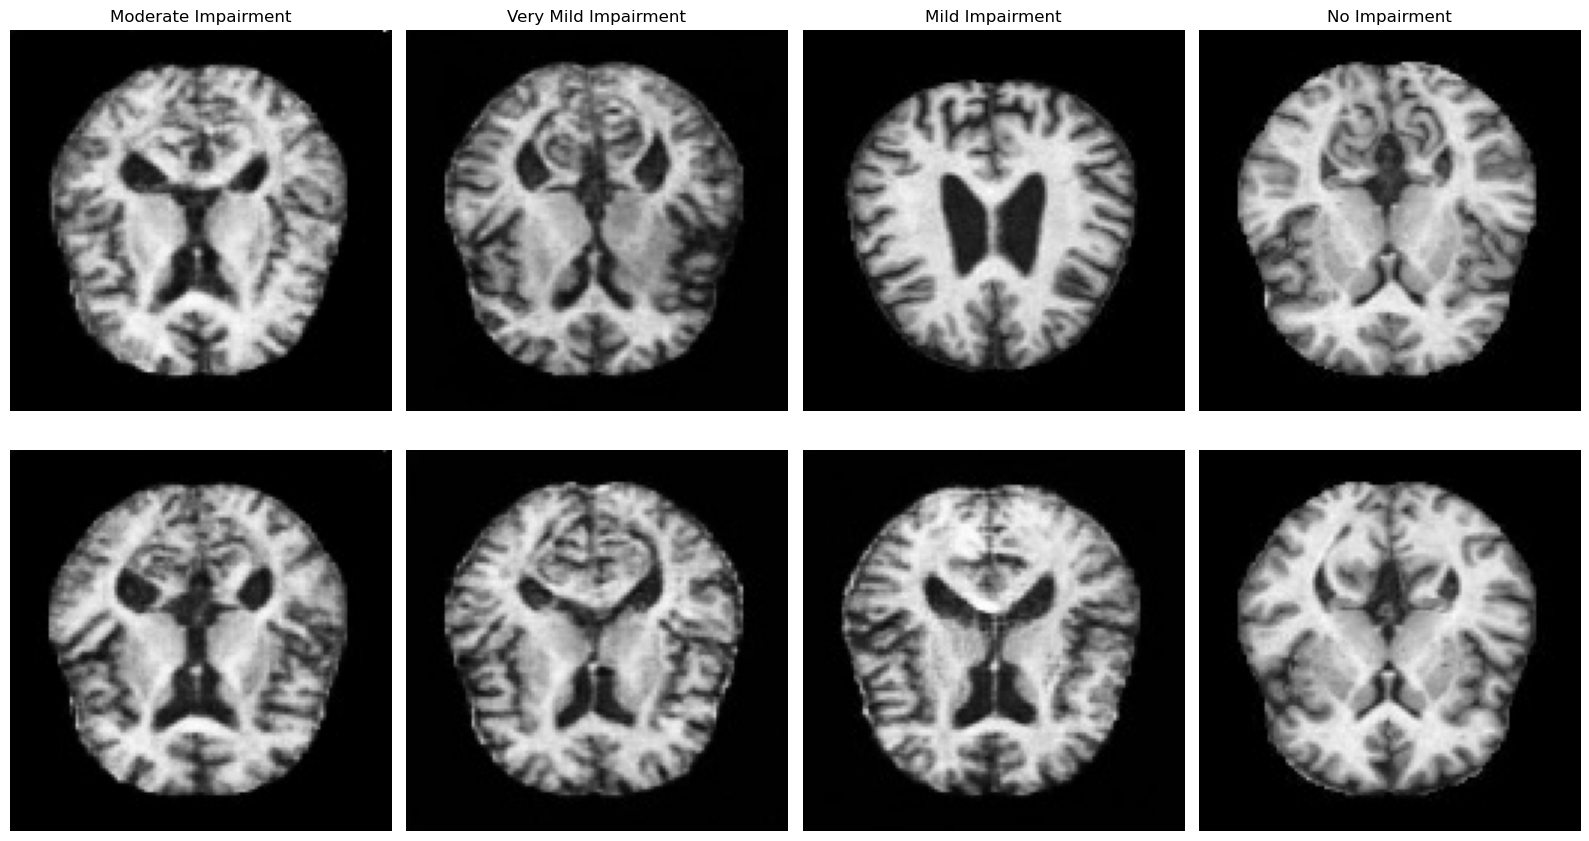

In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_by_impairment_type(df, impairment_types=['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment', 'No Impairment'], num=10):
    # Create a figure with 2 rows and len(impairment_types) columns
    fig, axes = plt.subplots(2, len(impairment_types), figsize=(16, 9))

    # Loop through each impairment type and select random images to display
    for i, impairment_type in enumerate(impairment_types):
        # Filter the DataFrame for the current impairment type
        impairment_data = df[df['Impairment_Type'] == impairment_type]
        
        # Randomly select 'num' images
        sampled_imgs = impairment_data.sample(n=num, random_state=42)
        
        # Plot the selected images for the current impairment type
        for j in range(num):
            img = sampled_imgs.iloc[j]['Image_Data']
            row = j // (num // 2)  # Determine row (0 or 1)
            col = j % (num // 2)  # Determine column position (0 to len(impairment_types) - 1)
            ax = axes[row, i]  # Select the appropriate subplot
            ax.imshow(img)
            ax.axis('off')
        
        # Set the title for the subplot
        axes[0, i].set_title(impairment_type)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_by_impairment_type(df, impairment_types=['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment', 'No Impairment'], num=10)


In [110]:
train, test = train_test_split(df,test_size=0.8,stratify=df['Impairment_Type'])

In [124]:

from torchvision import models
from torchvision.models import ResNet50_Weights

# Load the model with pre-trained weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all the layers
for param in model.parameters(): 
        param.requires_grad = False
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [119]:
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())
model = model.to(device)
model

AttributeError: 'Sequential' object has no attribute 'in_features'

In [ ]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained ResNet50 model
model = models.resnet50(weights='IMAGENET1K_V1')

# Get the number of input features to the original fully connected layer

in_features = model.fc.in_features

# Modify the fully connected layer (fc)
model.fc = nn.Sequential(
    nn.Linear(in_features, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),
    nn.LogSigmoid()
)
# Move the model to the appropriate device (e.g., 'cuda' or 'cpu')
model = model.to(device)


TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [77]:
df.head()

,Impairment_Type,Image_Name,Image_Path,Image_Data
0,Moderate Impairment,ModerateImpairment-802-_jpg.rf.4d240c4e9cd1071...,/Users/selahmitchell/Downloads/alzheimer detec...,"[[[0.0196078431372549, 0.0196078431372549, 0.0..."
1,Moderate Impairment,ModerateImpairment-926-_jpg.rf.d801d2fca121257...,/Users/selahmitchell/Downloads/alzheimer detec...,"[[[0.023529411764705882, 0.023529411764705882,..."
2,Moderate Impairment,ModerateImpairment-1289-_jpg.rf.4c1f14c4b0e529...,/Users/selahmitchell/Downloads/alzheimer detec...,"[[[0.01568627450980392, 0.01568627450980392, 0..."
3,Moderate Impairment,ModerateImpairment-1637-_jpg.rf.62fdb6b600da49...,/Users/selahmitchell/Downloads/alzheimer detec...,"[[[0.023529411764705882, 0.023529411764705882,..."
4,Moderate Impairment,ModerateImpairment-2204-_jpg.rf.4e44d25282395c...,/Users/selahmitchell/Downloads/alzheimer detec...,"[[[0.023529411764705882, 0.023529411764705882,..."


In [78]:
img = df['Image_Data'][0]  # Access image data (PIL Image)
img.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

In [48]:
train, test = train_test_split(df,test_size=0.8,stratify=df['Impairment_Type'])

In [49]:
print(train)

           Impairment_Type                                         Image_Name  \
2622  Very Mild Impairment  VeryMildImpairment-118-_jpg.rf.55e10430534418a...   
166    Moderate Impairment  ModerateImpairment-1206-_jpg.rf.e7773858f5509c...   
6988         No Impairment  NoImpairment-791-_jpg.rf.e0439b33568ccd046c790...   
7140         No Impairment  NoImpairment-1024-_jpg.rf.99fb6886424e09711f9a...   
1332   Moderate Impairment  ModerateImpairment-1540-_jpg.rf.988a0e7321c60d...   
...                    ...                                                ...   
9583         No Impairment  16-54-_jpg.rf.3d3f419495c9df10d92f4b58c0e9cf59...   
2584  Very Mild Impairment  VeryMildImpairment-1284-_jpg.rf.07ad1bc2959b91...   
1353   Moderate Impairment  ModerateImpairment-2305-_jpg.rf.53ab084d6a4529...   
5731       Mild Impairment  MildImpairment-1058-_jpg.rf.d1fefcc31f0f6c197a...   
4109  Very Mild Impairment  VeryMildImpairment-2526-_jpg.rf.52de600b1b0fa7...   

                           

In [52]:
import plotly.express as px 

fig = px.bar(train, x = 'Impairment_Type')
fig.show()

fig = px.bar(test, x = 'Impairment_Type')
fig.show()

In [ ]:
import os
import pandas as pd
from PIL import Image
import io
from google.colab import drive

# Mount Google Drive to access the files
drive.mount('/content/drive')

def create_image_dataframe(base_dir):
    # List to hold the rows of the dataframe
    data = []
    
    # Loop over the 'train' and 'test' directories
    for split in ['train', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Check if the split directory exists
        if not os.path.isdir(split_dir):
            print(f"Directory not found: {split_dir}")
            continue
        
        # Iterate over each impairment type directory within train/test
        for impairment_type in ['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment']:
            impairment_dir = os.path.join(split_dir, impairment_type)

            for img_name in os.listdir(impairment_dir):
                if img_name.lower().endswith('.jpg'):
                    # Full image path
                    img_path = os.path.join(impairment_dir, img_name)
                    
                    # Open the image and load it into memory as an object
                    with open(img_path, 'rb') as img_file:
                        img_data = img_file.read()  # Read the image file as bytes
                        img = Image.open(io.BytesIO(img_data))  # Open the image using Pillow
                    
                    # Append a new row with impairment type, image name, image path, and image data
                    data.append([impairment_type, img_name, img_path, img])  

    # Convert the list of data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['Impairment_Type', 'Image_Name', 'Image_Path', 'Image_Data'])
    return df

# Define your base directory where 'train' and 'test' folders are located in Google Drive
base_dir = '/content/drive/MyDrive/alzheimer_detection'  # Update path to reflect your Drive structure

# Generate the dataframe
df = create_image_dataframe(base_dir)

# Display the first few rows
print(df.head())
df.info()


In [ ]:
sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify= y=y)

In [55]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
#CBAM module